In [112]:
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [113]:
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end = pd.Timestamp.now().strftime('%Y-%m-%d'))

data

C:\Users\pnkdl\AppData\Local\Temp\ipykernel_8132\3615067833.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = "2020-01-01", end = pd.Timestamp.now().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095
...,...,...,...,...,...
2025-06-08,105793.648438,106497.062500,105075.328125,105617.507812,36626232328
2025-06-09,110294.101562,110561.421875,105400.234375,105793.023438,55903193732


In [114]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [121]:
class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.W_xh = np.random.randn(hidden_size, input_size) * 0.01
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.b_h = np.zeros((hidden_size, 1))
        self.W_hy = np.random.randn(output_size, hidden_size) * 0.01  # Изменено на output_size
        self.b_y = np.zeros((output_size, 1))  # Изменено на output_size
    
    def forward(self, inputs):
        h_prev = np.zeros((self.W_hh.shape[0], 1))
        self.hs = [h_prev]
        self.outputs = []
        for x in inputs:
            x = x.reshape(-1, 1)
            h = np.tanh(self.W_xh @ x + self.W_hh @ h_prev + self.b_h)
            y = self.W_hy @ h + self.b_y
            self.hs.append(h)
            self.outputs.append(y)
            h_prev = h
        return self.outputs[-1]
    
    def backward(self, inputs, target, lr=0.001):
        dW_xh, dW_hh, db_h = 0, 0, 0
        dW_hy, db_y = np.zeros_like(self.W_hy), np.zeros_like(self.b_y)
        dh_next = np.zeros_like(self.hs[0])
        
        dy = self.outputs[-1] - target.reshape(-1, 1)
        dW_hy += dy @ self.hs[-1].T
        db_y += dy
        
        dh = self.W_hy.T @ dy + dh_next
        
        for t in reversed(range(len(inputs))):
            x = inputs[t].reshape(-1, 1)
            h_current = self.hs[t+1]
            h_prev = self.hs[t]
            
            dtanh = (1 - h_current ** 2) * dh
            dW_xh += dtanh @ x.T
            dW_hh += dtanh @ h_prev.T
            db_h += dtanh
            
            dh = self.W_hh.T @ dtanh
        
        clip_value = 5.0
        for grad in [dW_xh, dW_hh, dW_hy]:
            np.clip(grad, -clip_value, clip_value, out=grad)
        
        self.W_xh -= lr * dW_xh
        self.W_hh -= lr * dW_hh
        self.b_h -= lr * db_h
        self.W_hy -= lr * dW_hy
        self.b_y -= lr * db_y


input_size = 5
hidden_size = 32
output_size = 5
lr = 0.001
epochs = 150

rnn = SimpleRNN(input_size, hidden_size, output_size)

loss_history = []
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(len(X_train)):
        inputs = X_train[i]
        target = y_train[i]
        output = rnn.forward(inputs)
        loss = np.sum((output - target.reshape(-1, 1)) ** 2) 
        epoch_loss += loss
        rnn.backward(inputs, target, lr)
    
    avg_loss = epoch_loss / len(X_train)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

Epoch 0, Loss: 2.426229
Epoch 10, Loss: 0.373703
Epoch 20, Loss: 0.370440
Epoch 30, Loss: 0.366932
Epoch 40, Loss: 0.361914
Epoch 50, Loss: 0.355552
Epoch 60, Loss: 0.350711
Epoch 70, Loss: 0.348591
Epoch 80, Loss: 0.347674
Epoch 90, Loss: 0.347109
Epoch 100, Loss: 0.346630
Epoch 110, Loss: 0.346229
Epoch 120, Loss: 0.346285
Epoch 130, Loss: 0.346205
Epoch 140, Loss: 0.346001


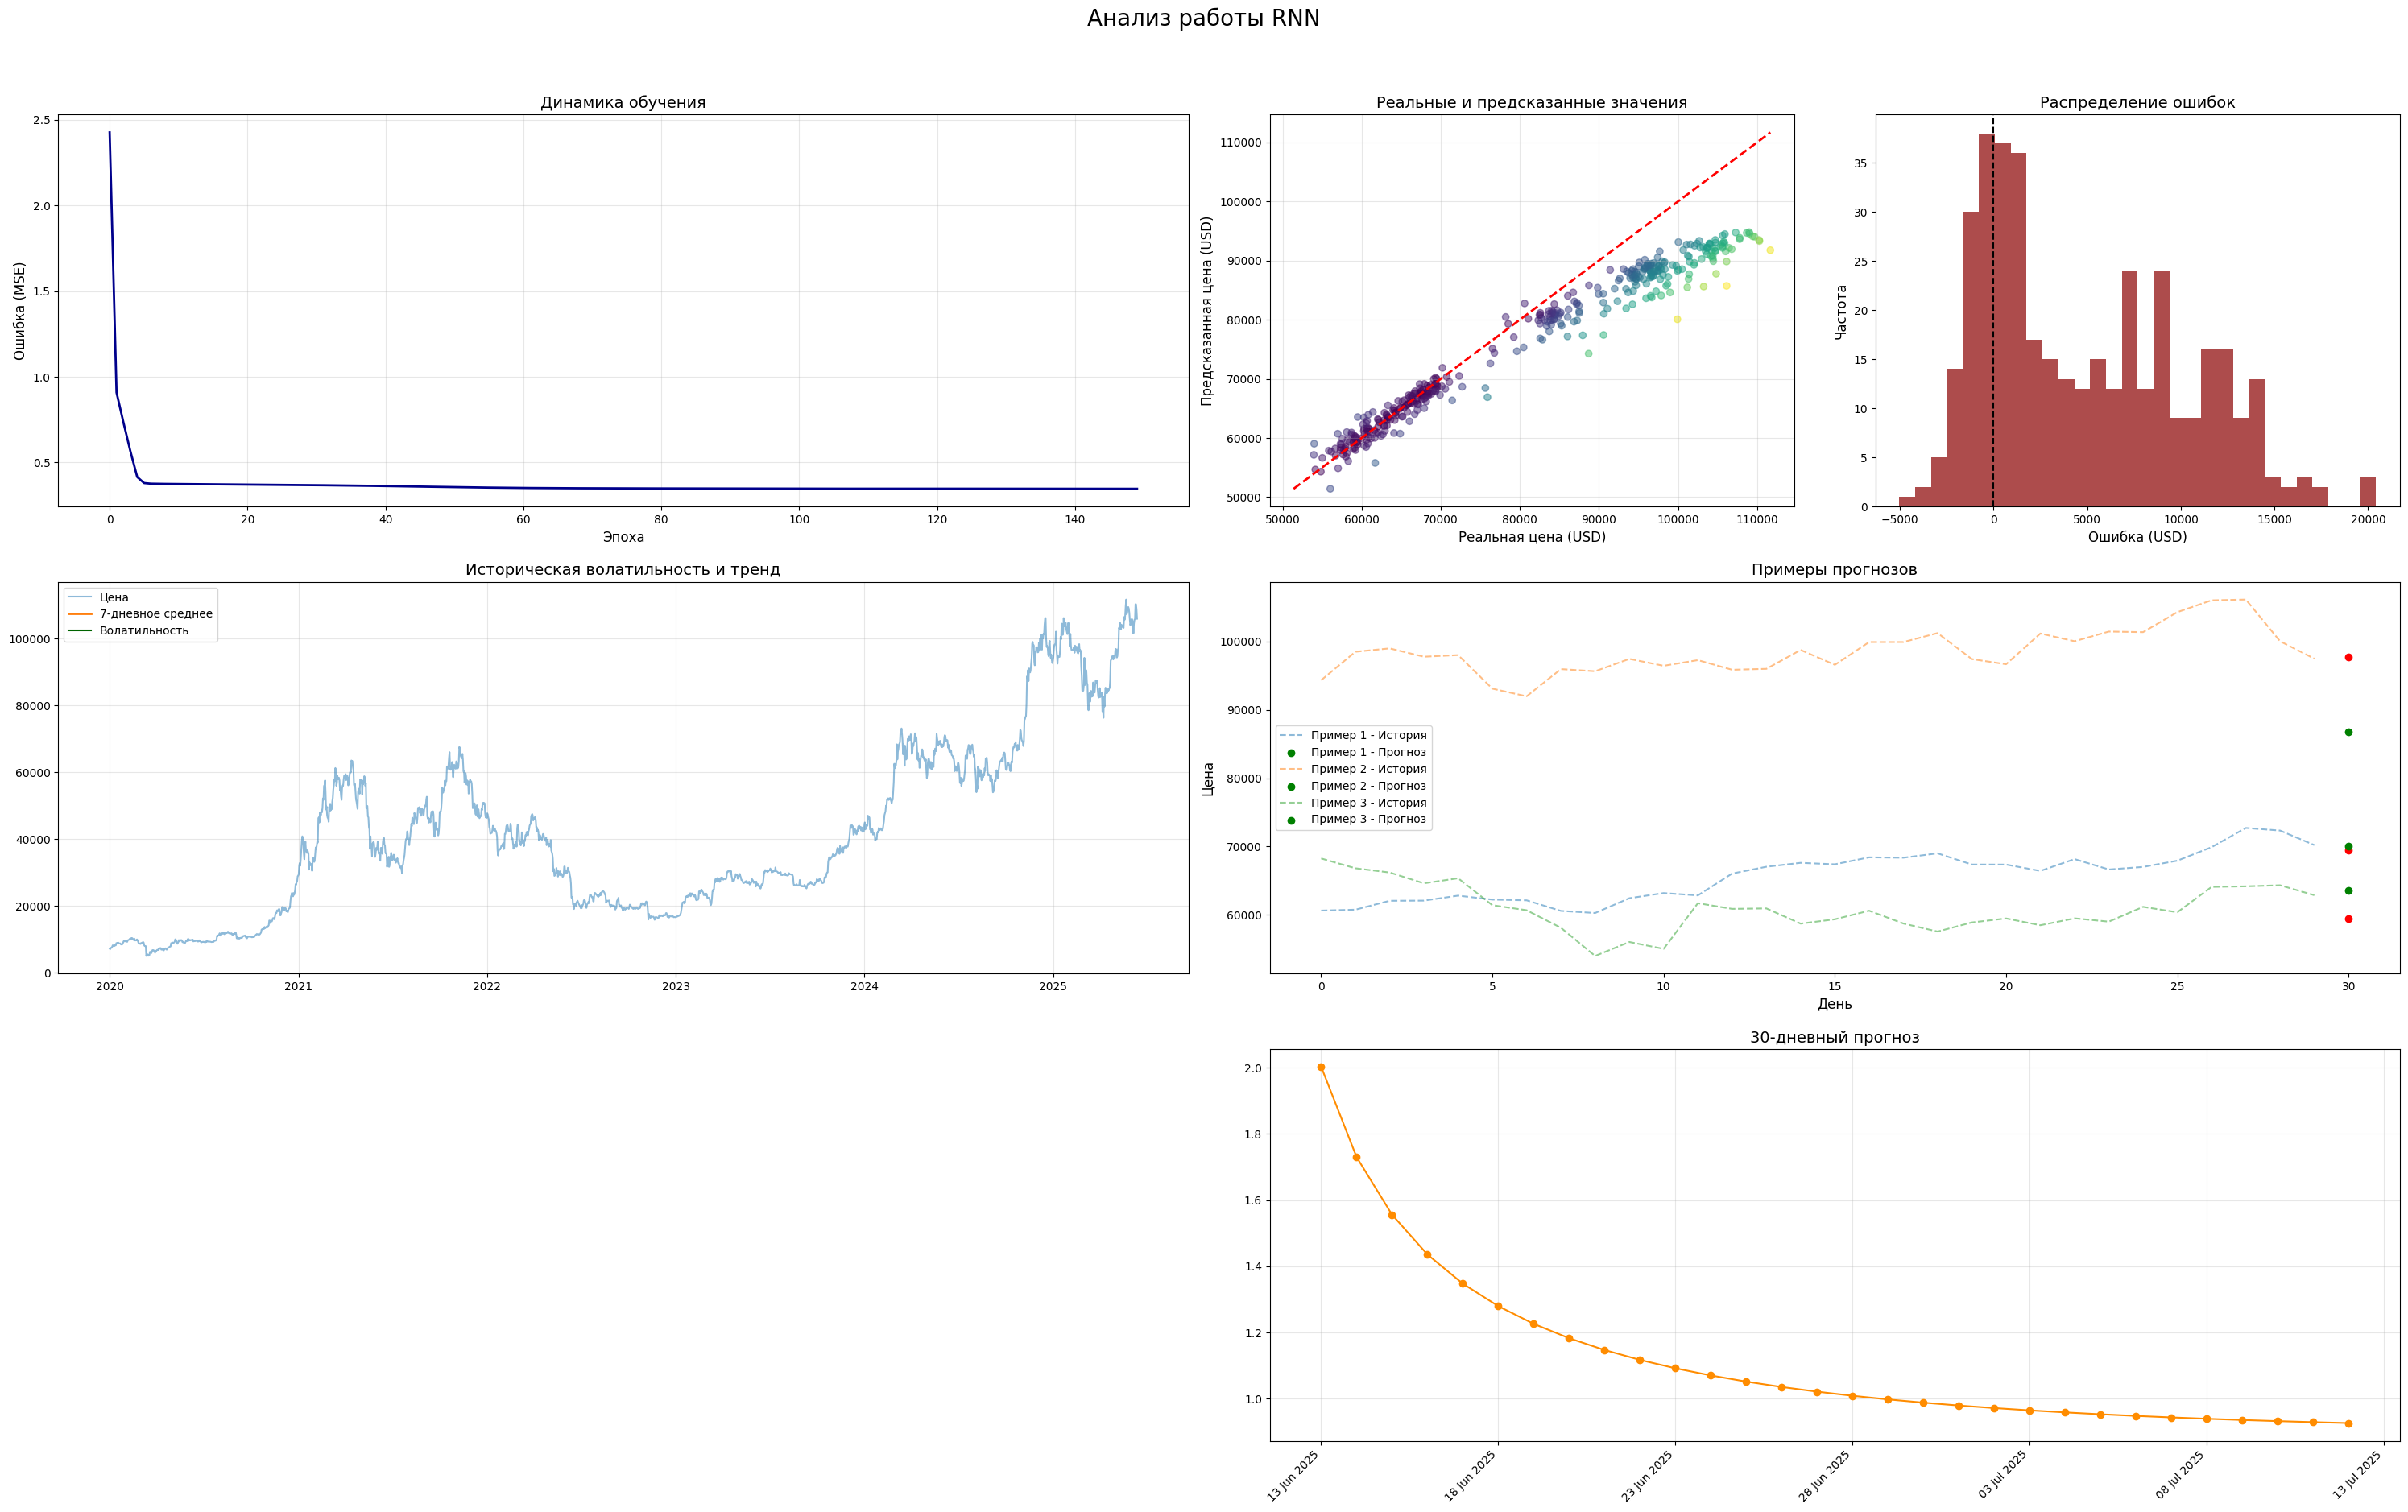

In [122]:
# Функция прогнозирования (теперь предсказываем 5 значений, но отображаем только одну переменную)
def forecast(model, last_sequence, days=30, target_var=0):
    predictions = []
    current_seq = last_sequence.copy()
    for _ in range(days):
        next_pred = model.forward(current_seq)
        predictions.append(next_pred[target_var].item())  # Выбираем только целевую переменную
        current_seq = np.vstack([current_seq[1:], next_pred.reshape(1, -1)])  # Обновляем последовательность
    return predictions

# Генерация предсказаний на тестовых данных (для всех 5 переменных)
test_preds = []
for i in range(len(X_test)):
    inputs = X_test[i]  # Убран reshape, так как входные данные уже правильной формы (60,5)
    output = rnn.forward(inputs)
    test_preds.append(output)  # Сохраняем все 5 предсказаний

# Преобразование предсказаний обратно в исходный масштаб
test_preds_array = np.array(test_preds).reshape(len(test_preds), -1)  # (n_samples, 5)
test_predictions_inv = scaler.inverse_transform(test_preds_array)  # Все переменные
y_test_inv = scaler.inverse_transform(y_test)  # Все переменные

# Прогноз на N дней (показываем только целевую переменную)
last_sequence = scaled_data[-seq_length:]  # Последовательность без reshape
target_variable_index = 0  # Индекс целевой переменной (например, цена закрытия)
scaled_forecast = forecast(rnn, last_sequence, days=30, target_var=target_variable_index)
forecast_prices = np.array(scaled_forecast).reshape(-1, 1)  # Только целевая переменная

# Создание единой фигуры с subplots (все графики адаптированы под многомерные предсказания)
plt.figure(figsize=(30, 25))
plt.suptitle("Анализ работы RNN", y=0.95, fontsize=20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=2)
ax1.plot(loss_history, color="darkblue", linewidth=2)
ax1.set_title("Динамика обучения", fontsize=14)
ax1.set_xlabel("Эпоха", fontsize=12)
ax1.set_ylabel("Ошибка (MSE)", fontsize=12)
ax1.grid(True, alpha=0.3)

# 2. Сравнение реальных и предсказанных значений (только целевая переменная)
ax2 = plt.subplot2grid((4, 4), (0, 2))
ax2.scatter(y_test_inv[:, target_variable_index], test_predictions_inv[:, target_variable_index], 
            alpha=0.5, c=np.abs(y_test_inv[:, target_variable_index] - test_predictions_inv[:, target_variable_index]), 
            cmap="viridis")

min_val = min(y_test_inv[:, target_variable_index].min(), test_predictions_inv[:, target_variable_index].min())
max_val = max(y_test_inv[:, target_variable_index].max(), test_predictions_inv[:, target_variable_index].max())
ax2.plot([min_val, max_val], [min_val, max_val], "--r", linewidth=2)

ax2.set_title("Реальные и предсказанные значения", fontsize=14)
ax2.set_xlabel("Реальная цена (USD)", fontsize=12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize=12)
ax2.grid(alpha=0.3)

# 3. Распределение ошибок (только целевая переменная)
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test_inv[:, target_variable_index] - test_predictions_inv[:, target_variable_index]
ax3.hist(errors, bins=30, color="darkred", alpha=0.7)
ax3.set_title("Распределение ошибок", fontsize=14)
ax3.set_xlabel("Ошибка (USD)", fontsize=12)
ax3.set_ylabel("Частота", fontsize=12)
ax3.axvline(x=0, color="black", linestyle="--")

# 4. Скользящее среднее и волатильность
ax4 = plt.subplot2grid((4, 4), (1, 0), colspan=2)
window_size = 7
data["MA_7"] = data["Close"].rolling(window=window_size).mean()
data["Volatility"] = data["Close"].rolling(window=window_size).std()
ax4.plot(data["Close"], label="Цена", alpha=0.5)
ax4.plot(data["MA_7"], label="7-дневное среднее", linewidth=2)
ax4.plot(data["Volatility"], label="Волатильность", color="darkgreen")
ax4.set_title("Историческая волатильность и тренд", fontsize=14)
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Примеры прогнозов (только целевая переменная)
ax5 = plt.subplot2grid((4, 4), (1, 2), colspan=2)
for i in range(3):
    idx = np.random.randint(len(X_test))
    seq = X_test[idx]
    pred = rnn.forward(seq)  # Получаем все 5 предсказаний
    real = y_test_inv[idx, target_variable_index]
    pred_single = test_predictions_inv[idx, target_variable_index]
    
    # Обратное преобразование только целевой переменной из истории
    history_single = scaler.inverse_transform(seq)[:, target_variable_index]
    
    ax5.plot(history_single, alpha=0.5, linestyle="--", label=f"Пример {i+1} - История")
    ax5.scatter(len(history_single), real, color="red", zorder=5)
    ax5.scatter(len(history_single), pred_single, color="green", zorder=5, label=f"Пример {i+1} - Прогноз")
ax5.set_title("Примеры прогнозов", fontsize=14)
ax5.set_xlabel("День", fontsize=12)
ax5.set_ylabel("Цена", fontsize=12)
ax5.legend()

# 8. Долгосрочный прогноз (только целевая переменная)
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan=2)
forecast_dates = pd.date_range(start=data.index[-1], periods=31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker="o", markersize=6, linestyle="-", color="darkorange")
ax8.set_title("30-дневный прогноз", fontsize=14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.setp(ax8.get_xticklabels(), rotation=45, ha="right")
ax8.grid(True, alpha=0.3)


plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

## Выводы

причины несовпадения предсказаний с реальными данными:

- лосс при обучении сходится к константе, при этом при увеличении числа эпох предсказания на валидационной выборке все же немного улучшаются.

- Архитектура модели маленькая и простая для предсказания такой сложной зависимости.

- Данных для обучения недостаточно, так как понятно что цена биткоина зависит не только от цены закрытия в прошлые дни, но и от множества других факторов, которые недоступны модели, тут попробовали использовать все параметры которые есть в датасете(close, high, low, open, volume) но сильного прироста это не дало.

- Используется итеративное предсказание (каждый шаг зависит от предыдущего прогноза), что приводит к сильному накоплению ошибок, из-за того что модель предсказывает на своих же предсказаниях.

- MinMaxScaler не учитывает что могут быть значения не встреченные в тестовой выборке,однако его замена на другие(StandardScaler) не повлияло на ситуацию.